In [ ]:
# Jason Qin
# 04/20/21

# Analyzing Generated Data

In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist, hamming
import scipy.stats

from tape.datasets import FastaDataset, pad_sequences
from tape.tokenizers import TAPETokenizer

### Finding Perfect Predictions in Generated Data

In [6]:
data_file = '/group/ag_cmb/scratch/jqin/projects/tape/results/tcr_transformer_21-04-08-22-42-38_231772/generate_results_3_220421_043126.txt'
data = pandas.read_csv(data_file, sep='\t')

In [7]:
# clean and organize data
column_names = ['TCR', 'antigen', 'prediction']
for col in column_names:
    # remove all non-numeric parts of data
    data[col] = data[col].str.replace(r'.*\[', '')
    data[col] = data[col].str.replace(r'\].*', '')
    data[col] = data[col].str.replace(r'        ', ',')
    data[col] = data[col].str.strip()
    
    # convert comma-separated string of ints to list of ints
    data[col] = [np.array([int(float(y.strip('.'))) for y in x]) for x in data[col].str.split(',')]

<ipython-input-7-48522cd36268>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'.*\[', '')
<ipython-input-7-48522cd36268>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\].*', '')


In [8]:
antigens = data['antigen']
predictions = data['prediction']

In [9]:
# reduce length of predictions to be closest to each antigen
# this lets us find the closest match between the targets and the
# generated predictions
truncated_predictions = []
for antigen, pred in zip(antigens, predictions):
    stop_idx = np.where(antigen == 3)[0][0]
    if antigen.shape[0] < pred.shape[0]:
        pred[stop_idx] = 3
        pred = pred[0:(stop_idx+1)]
    truncated_predictions += [pred]

In [10]:
# compare truncated predictions to the known targets
truncated_differences = []
for antigen, pred in zip(antigens, truncated_predictions):
    antigen = np.expand_dims(antigen, 0)
    pred = np.expand_dims(pred, 0)
    truncated_differences += [cdist(antigen, pred, metric='hamming').squeeze()]

In [11]:
# truncated predictions and Hamming distance scores of truncated predictions
# to data frame
data['truncated_prediction'] = truncated_predictions
data['truncated_difference'] = truncated_differences

In [12]:
# find all sequences that were perfectly predicted
perf_preds = data[data['truncated_difference'] == 0]['truncated_prediction']

In [13]:
print('Number of total sequences with predictions: {}'.format(data.shape[0]))
print('Number of perfect predictions (after truncation): {}'.format(len(perf_preds)))

Number of total sequences with predictions: 3936
Number of perfect predictions (after truncation): 761


In [14]:
# how many of the unique sequences are there in those that were 
# perfectly predicted?
unique_perf_preds = [list(y) for y in set(tuple(x) for x in perf_preds)]

In [15]:
print('Among perfect predictions, number of unique sequences: {}'.format(len(unique_perf_preds)))

Among perfect predictions, number of unique sequences: 39


In [16]:
# how many times does each of the N unique sequences get generated?
unique_pred_counts = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in perf_preds]
    unique_pred_counts += [sum(pred_match)]

[2, 3, 1, 1, 1, 14, 46, 4, 3, 1, 4, 1, 2, 3, 3, 2, 300, 1, 1, 1, 4, 2, 49, 3, 6, 4, 1, 3, 2, 3, 17, 1, 1, 1, 1, 4, 248, 10, 7]


(array([35.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([  1. ,  30.9,  60.8,  90.7, 120.6, 150.5, 180.4, 210.3, 240.2,
        270.1, 300. ]),
 <BarContainer object of 10 artists>)

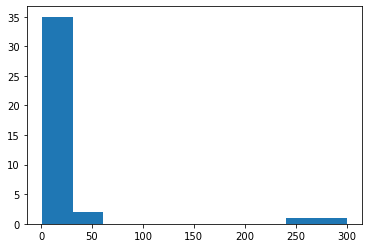

In [18]:
print(unique_pred_counts)
plt.hist(unique_pred_counts)

### Compare Training Data to Validation Data

In [19]:
# relevant data files
data_dir = '/group/ag_cmb/scratch/jqin/projects/tape/data/tcr'
cdr3_train_file = data_dir + '/cdr3_train.fasta'
antigen_train_file = data_dir + '/antigen_train.fasta'
cdr3_valid_file = data_dir + '/cdr3_valid.fasta'
antigen_valid_file = data_dir + '/antigen_valid.fasta'

# set up tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# load relevant data
antigen_train_data_uncleaned = FastaDataset(antigen_train_file, in_memory=True)

In [20]:
# organize data
antigen_train_data = [list(tokenizer.encode(x['primary'])) for x in antigen_train_data_uncleaned]

In [21]:
# find number of times each unique perfect (truncated) prediction 
# can be found in training data
unique_pred_counts_in_train = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in antigen_train_data]
    unique_pred_counts_in_train += [sum(pred_match)]

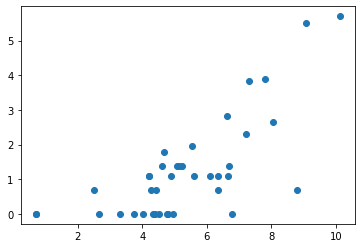

In [22]:
plt.scatter(np.log(unique_pred_counts_in_train), np.log(unique_pred_counts))

In [23]:
# what is correlation between Hamming distance and number of same
# antigens seen in training data?
all_pred_counts_in_train = []
for pred in truncated_predictions:
    pred_match = [list(x) == list(pred) for x in antigen_train_data]
    all_pred_counts_in_train += [sum(pred_match)]

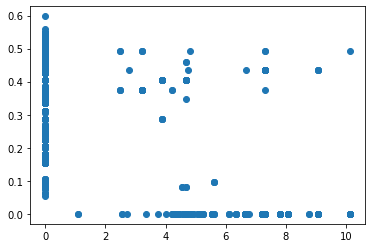

In [24]:
plt.scatter(np.log(np.array(all_pred_counts_in_train)+1), np.log(np.array(truncated_differences)+1))